In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

In [2]:
df = pd.read_csv(r"D:\CampMain\DSMP 1.0\2) Python\3) Data analysis Process\Data Analysis Projects\04 Insurance\insurance_data.csv").drop(columns=["index", "PatientID"])

In [3]:
data = df.copy()

In [4]:
data.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [4]:
def check_missing(df):
    X = (df.isnull().sum() / df.shape[0] ).mul(100).round(2).sort_values(ascending=False).reset_index().rename(columns={'index':'feature',0:'missing_percentage'})
    return X[X['missing_percentage']>0]


check_missing(data)

,feature,missing_percentage
0,age,0.37
1,region,0.22


<Axes: >

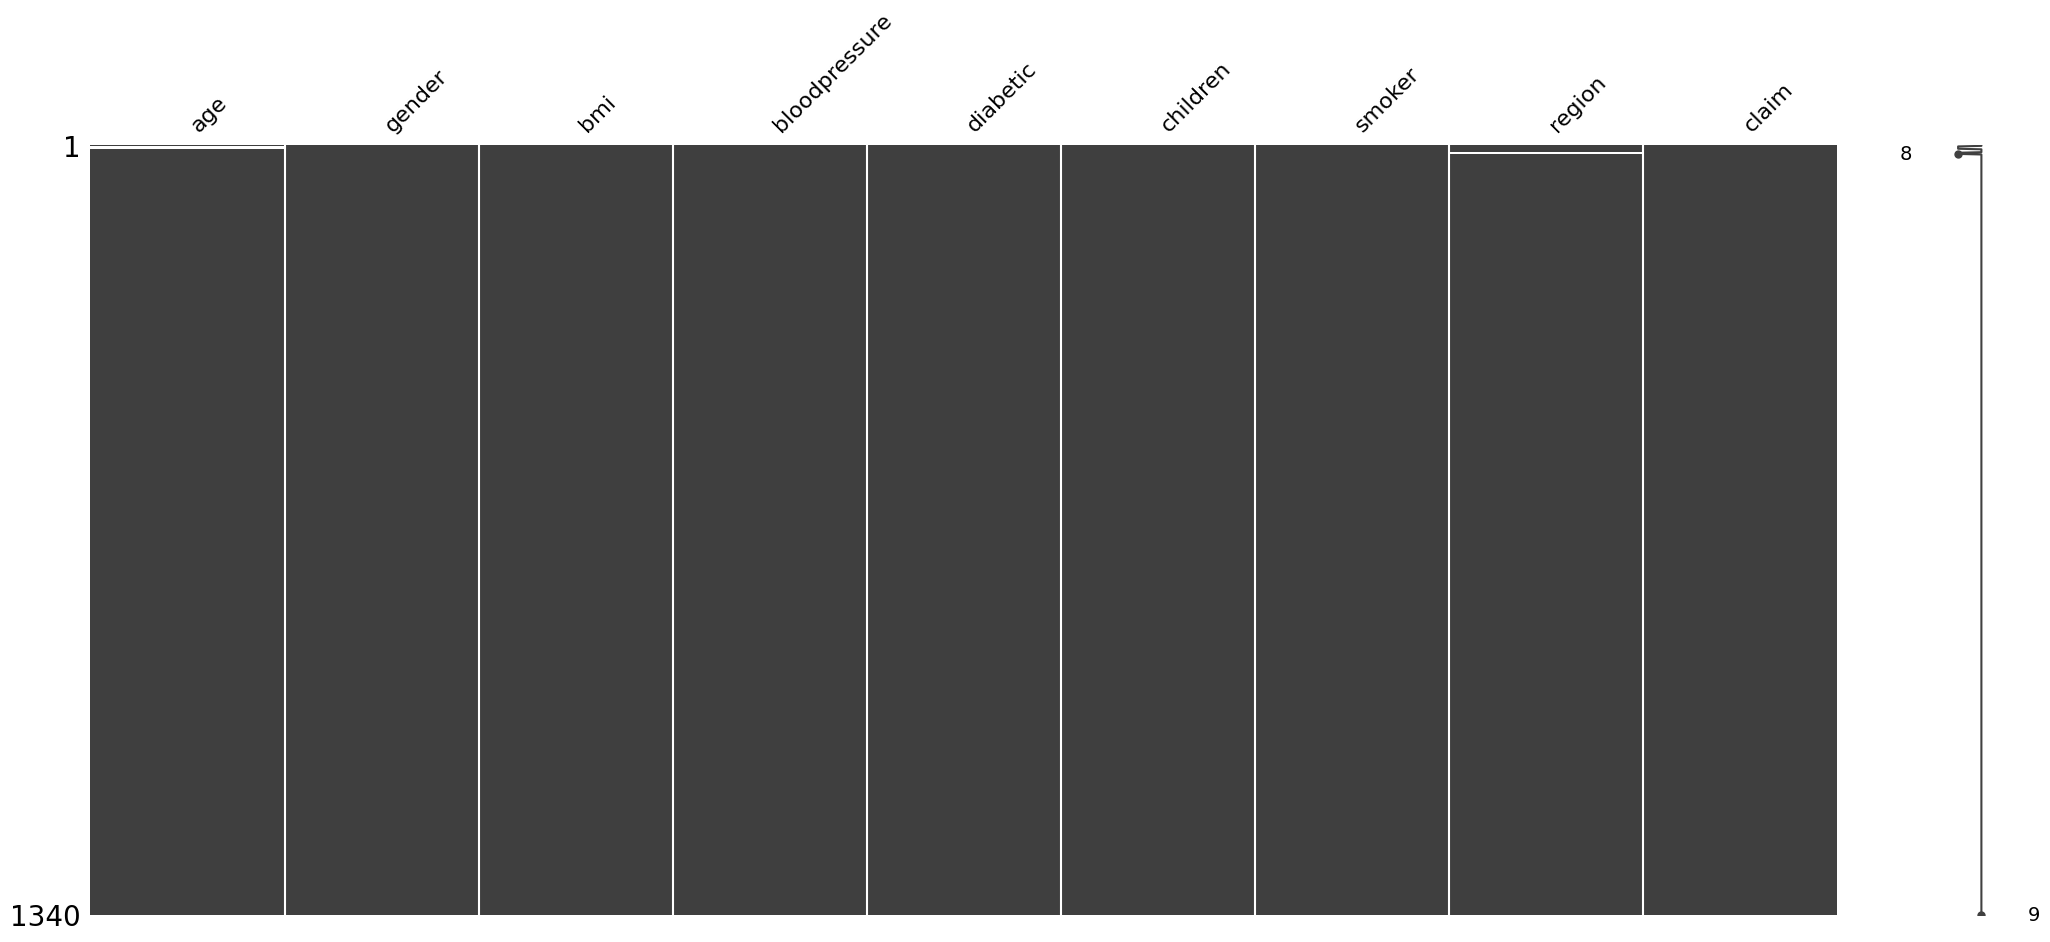

In [7]:
msno.matrix(data)

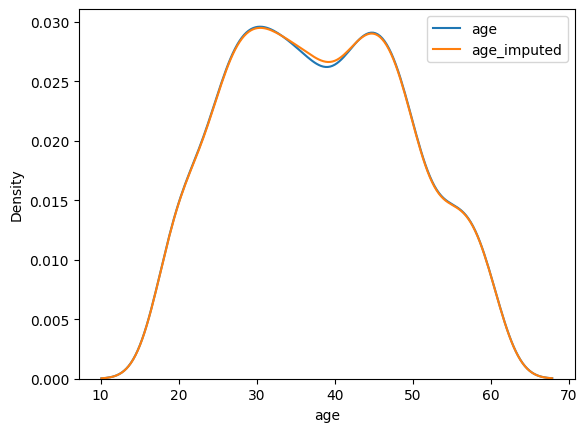

In [14]:
X = data['age']
y = data['age'].fillna(np.mean(X))

sns.kdeplot(X,)
sns.kdeplot(y,)
plt.legend(['age','age_imputed'])
plt.show()

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, pearsonr, spearmanr

class Missing_Type:
    def __init__(self, df):
        self.df = df
    
    def is_mcar_numeric(self, target_col, other_cols=None, max_iter=10, random_state=42, plot=False):
        df = self.df.select_dtypes(include=[np.number])
        complete_data = df.dropna()

        imp = IterativeImputer(max_iter=max_iter, random_state=random_state)
        imputed_data = imp.fit_transform(df)
        imputed_data = pd.DataFrame(imputed_data, columns=df.columns)

        if df[target_col].isnull().sum() > 0:
            missing_index = df[df[target_col].isnull()].index
            not_missing_index = df[~df[target_col].isnull()].index
            missing_data = df.loc[missing_index]
            not_missing_data = df.loc[not_missing_index]

            if plot:
                for col in (other_cols or []):
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
                    sns.kdeplot(df.loc[missing_index][col], color='red', label=f'With Missing {target_col}', ax=axes[0])
                    sns.kdeplot(df.loc[not_missing_index][col], color='blue', label=f'Without Missing {target_col}', ax=axes[0])
                    sns.kdeplot(imputed_data.loc[missing_index][col], color='red', label=f'With Missing {target_col} Imputed', ax=axes[1])
                    sns.kdeplot(imputed_data.loc[not_missing_index][col], color='blue', label=f'Without Missing {target_col} Imputed', ax=axes[1])
                    axes[0].set_title(f'With Missing {target_col}')
                    axes[1].set_title(f'Without Missing {target_col}')
                    axes[0].legend()
                    axes[1].legend()
                    plt.show()

            t_stat, p_value = ttest_ind(complete_data[target_col].dropna(), imputed_data[target_col].dropna())
            print(f'Column: {target_col}, t-statistic: {t_stat}, p-value: {p_value}')
     
            if p_value < 0.05:
                print(f'Missing data in column {target_col} may not be MCAR')
            else:
                print(f'Missing data in column {target_col} may be MCAR')

            for col in (other_cols or []):
                t_stat, p_val = ttest_ind(missing_data[col], not_missing_data[col], nan_policy='omit')
                print(f"Column: {col}, T-statistic: {t_stat}, P-value: {p_val}")
                if p_val < 0.05:
                    print(f'Missing data due to {target_col} in column {col} may not be MCAR')
                else:
                    print(f'Missing data due to {target_col} in column {col} may be MCAR')
        else:
            print(f'Column {target_col} has no missing values')

    def is_mcar_categorical(self, plot=False):
        data = self.df.select_dtypes(include=['object', 'bool'])
        
        for col in data.columns:
            if data[col].isnull().sum() > 0:
                contingency_table = pd.crosstab(data[col].isnull(), self.df.isnull().sum(axis=1))
                chi2, p, dof, ex = chi2_contingency(contingency_table)
                print(f'Column: {col}, Chi-square: {chi2}, p-value: {p}')
                
                if p < 0.05:
                    print(f'Missing data in {col} may not be MCAR')
                else:
                    print(f'Missing data in {col} may be MCAR')
                
                if plot:
                    plt.figure(figsize=(10, 6))
                    sns.heatmap(pd.isnull(self.df).corr(), annot=True, cmap="coolwarm")
                    plt.title(f'Missing Data Pattern for {col}')
                    plt.show()

    def is_mar_numeric(self, target_col, other_cols=None, max_iter=10, random_state=42, plot=False):
        df = self.df.select_dtypes(include=[np.number])

        imp = IterativeImputer(max_iter=max_iter, random_state=random_state)
        imputed_data = imp.fit_transform(df)
        imputed_data = pd.DataFrame(imputed_data, columns=df.columns)

        if df[target_col].isnull().sum() > 0:
            missing_index = df[df[target_col].isnull()].index
            not_missing_index = df[~df[target_col].isnull()].index
            if plot:

                for col in (other_cols or []):
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
                    sns.kdeplot(df.loc[missing_index][col], color='red', label=f'With Missing {target_col}', ax=axes[0])
                    sns.kdeplot(df.loc[not_missing_index][col], color='blue', label=f'Without Missing {target_col}', ax=axes[0])
                    sns.kdeplot(imputed_data.loc[missing_index][col], color='red', label=f'With Missing {target_col} Imputed', ax=axes[1])
                    sns.kdeplot(imputed_data.loc[not_missing_index][col], color='blue', label=f'Without Missing {target_col} Imputed', ax=axes[1])
                    axes[0].set_title(f'With Missing {target_col}')
                    axes[1].set_title(f'Without Missing {target_col}')
                    axes[0].legend()
                    axes[1].legend()
                    plt.show()
            
            df['target_missing'] = df[target_col].isnull().astype(int)
            for col in (other_cols or []):
                pearson_corr, pearson_p_value = pearsonr(df[col], df['target_missing'])
                spearman_corr, spearman_p_value = spearmanr(df[col], df['target_missing'])
                print(f'Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}')
                print(f'Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}')
                if pearson_p_value < 0.05:
                    print(f"Missing data in {col} depends on {target_col} (MAR) based on Pearson correlation")
                else:
                    print(f"Missing data in {col} does not depend on {target_col} (Not MAR) based on Pearson correlation")

                if spearman_p_value < 0.05:
                    print(f"Missing data in {col} depends on {target_col} (MAR) based on Spearman correlation")
                else:
                    print(f"Missing data in {col} does not depend on {target_col} (Not MAR) based on Spearman correlation")


    def is_mar_categorical(self, target_col, plot=False):
        data = self.df.select_dtypes(include=['object', 'bool'])
        missing_col = self.df[target_col].isnull()
        
        for col in data.columns:
            if col != target_col:
                contingency_table = pd.crosstab(data[col], missing_col)
                chi2, p, dof, ex = chi2_contingency(contingency_table)
                print(f'Column: {col}, Chi-square: {chi2}, p-value: {p}')
                
                if p < 0.05:
                    print(f'Missing data in {target_col} may be MAR due to {col}')
                else:
                    print(f'Missing data in {target_col} may not be MAR due to {col}')
                
        if plot:
            plt.figure(figsize=(10, 6))
            sns.heatmap(pd.isnull(self.df).corr(), annot=True, cmap="coolwarm")
            plt.title(f'Missing Data Pattern for {target_col} and {col}')
            plt.show()

    def is_mnar_numeric(self, target_col, plot=False):
        df = self.df.copy()
        df['missing'] = df[target_col].isnull()

        if plot:
            plt.figure(figsize=(12, 8))
            sns.pairplot(df, hue='missing', markers=["o", "s"])
            plt.suptitle(f'Missing Data Pattern for {target_col}', y=1.02)
            plt.show()

        print(f'Visual inspection of plots for MNAR in {target_col}')

    def is_mnar_categorical(self, target_col, plot=False):
        data = self.df.copy()
        data['missing'] = data[target_col].isnull()

        if plot:
            plt.figure(figsize=(10, 6))
            sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
            plt.title(f'Correlation Matrix including missing indicator for {target_col}')
            plt.show()

        print(f'Visual inspection of correlation matrix for MNAR in {target_col}')


mt = Missing_Type(df)


MCAR Numerical:


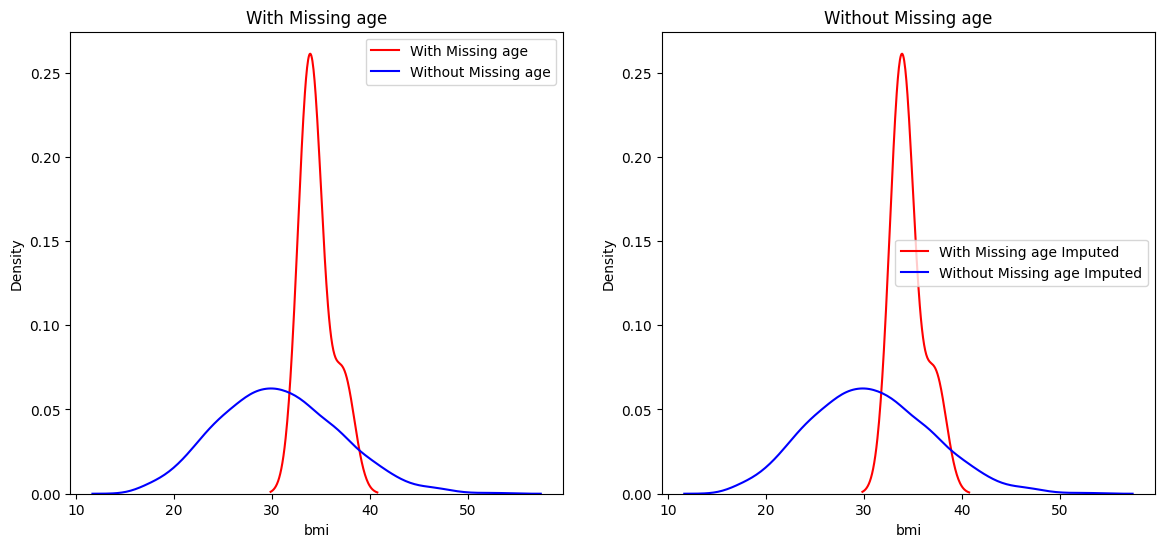

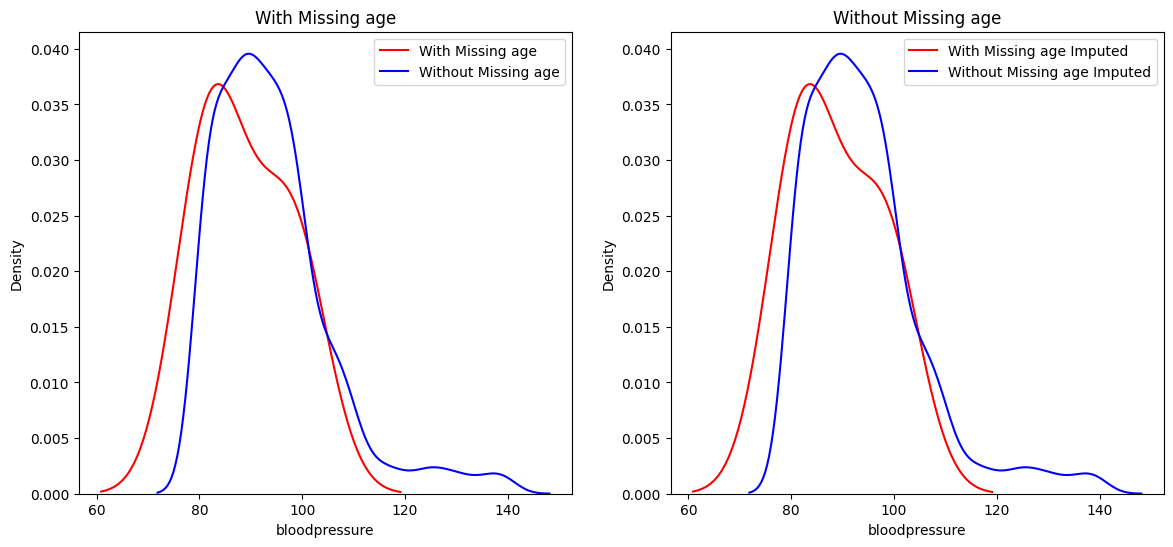

Column: age, t-statistic: -0.0027028895237611135, p-value: 0.9978436104982344
Missing data in column age may be MCAR
Column: bmi, T-statistic: 1.427980874267131, P-value: 0.15353072502550857
Missing data due to age in column bmi may be MCAR
Column: bloodpressure, T-statistic: -1.0496565184793858, P-value: 0.29406561286701016
Missing data due to age in column bloodpressure may be MCAR


In [79]:
print("\nMCAR Numerical:")
mt.is_mcar_numeric(target_col='age', other_cols=['bmi', 'bloodpressure'], plot=True)


MCAR Categorical:
Column: region, Chi-square: 346.81862677935976, p-value: 2.0889960346622855e-77
Missing data in region may not be MCAR


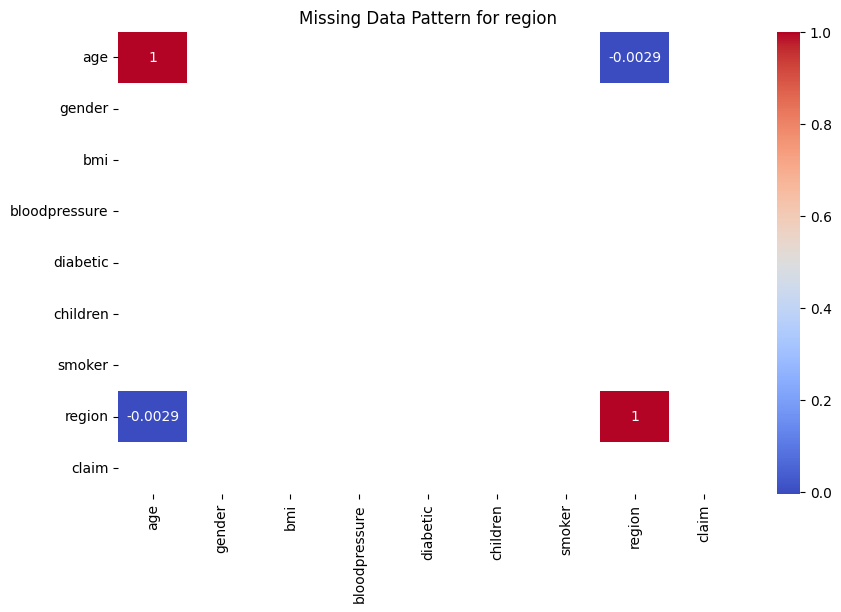

In [80]:
print("\nMCAR Categorical:")
mt.is_mcar_categorical(plot=True)


MAR Numerical:


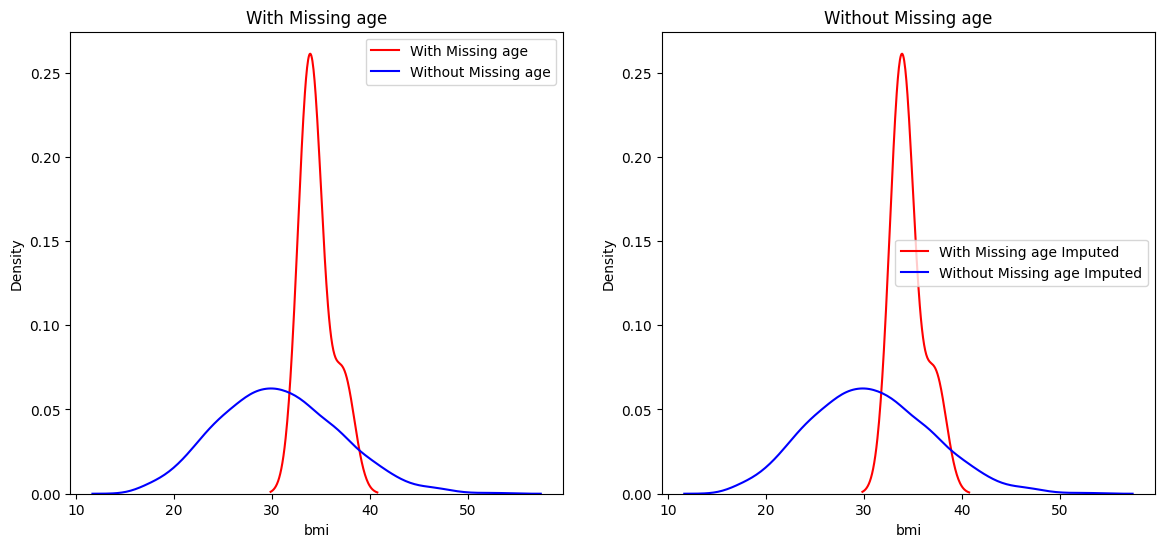

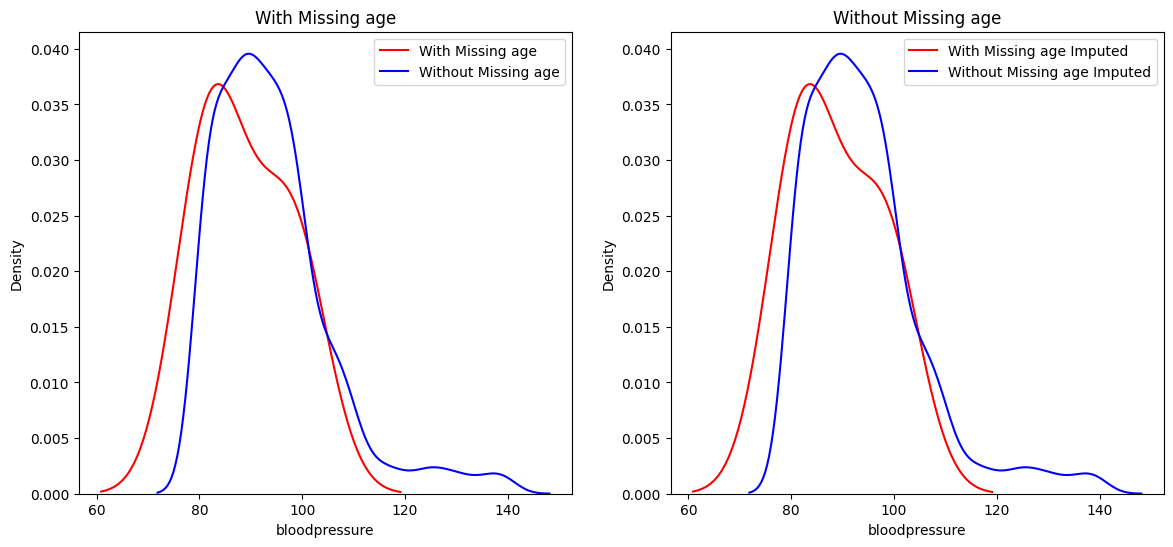

Pearson correlation: 0.039008895219195976, p-value: 0.15353072502550863
Spearman correlation: 0.050849225869863304, p-value: 0.06276479189363307
Missing data in bmi does not depend on age (Not MAR) based on Pearson correlation
Missing data in bmi does not depend on age (Not MAR) based on Spearman correlation
Pearson correlation: -0.028684046222183093, p-value: 0.29406561286701016
Spearman correlation: -0.029429570814972272, p-value: 0.28169164578572753
Missing data in bloodpressure does not depend on age (Not MAR) based on Pearson correlation
Missing data in bloodpressure does not depend on age (Not MAR) based on Spearman correlation


In [90]:
print("\nMAR Numerical:")
mt.is_mar_numeric(target_col='age', plot=True, other_cols=['bmi', 'bloodpressure'], random_state=42)


MAR Categorical:
Column: gender, Chi-square: 1.2890691993874495, p-value: 0.256219556221357
Missing data in region may not be MAR due to gender
Column: diabetic, Chi-square: 0.005260418032185866, p-value: 0.9421811349937025
Missing data in region may not be MAR due to diabetic
Column: smoker, Chi-square: 0.02642600694326617, p-value: 0.8708642697792097
Missing data in region may not be MAR due to smoker


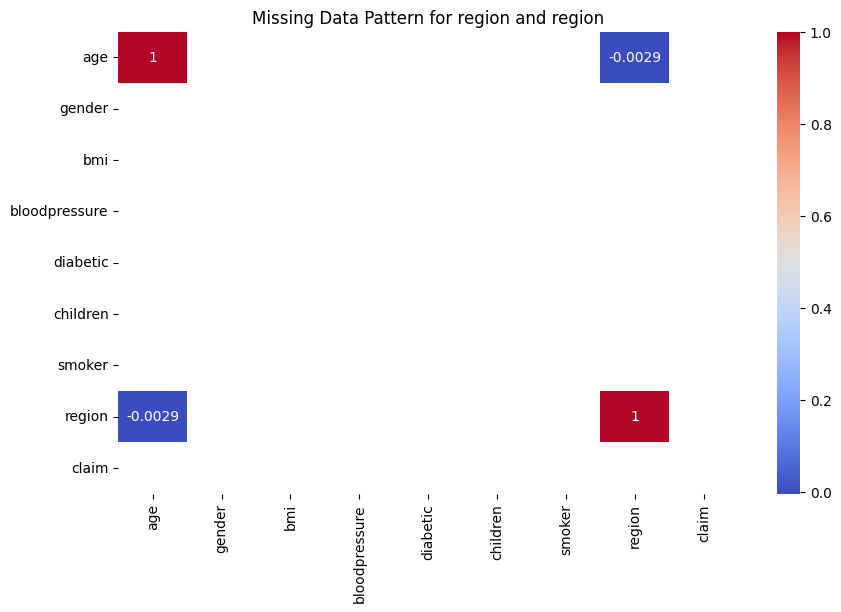

In [93]:
print("\nMAR Categorical:")
mt.is_mar_categorical(target_col='region', plot=True)

In [ ]:
print("\nMNAR Numerical:")
mt.is_mnar_numeric(target_col='age', plot=True)

In [ ]:
print("\nMNAR Categorical:")
mt.is_mnar_categorical(target_col='age', plot=True)

In [6]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from scipy import stats

# Define available imputers and scalers
IMPUTERS = {
    'SimpleImputer': SimpleImputer(strategy='mean'),
    'MissingIndicator': MissingIndicator(),
    'KNNImputer': KNNImputer(),
    'IterativeImputer': IterativeImputer(max_iter=10, random_state=123)
}

SCALERS = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'PowerTransformer': PowerTransformer()
}

ENCODERS = {
    'OneHotEncoder': OneHotEncoder(drop='first'),
    'OrdinalEncoder': OrdinalEncoder()
}

class Laveena:
    def __init__(self, df):
        """
        Initialize the Laveena class.
        
        Parameters:
        df (pd.DataFrame): Input dataframe.
        """
        self.df = df.copy()
        self.imputer = None
        self.scaler = None
        self.data = self.df.copy()

    def impute(self, imputer='SimpleImputer', columns=None,get_data = False, **kwargs ):
        """
        Perform imputation on the dataframe.
        
        Parameters:
        imputer (str): Imputer method. Default is 'SimpleImputer'.
        columns (list): List of columns to impute. If None, impute all columns.
        **kwargs: Additional parameters for the imputer.
        """
        self.imputer = IMPUTERS[imputer]
        if columns is None:
            self.data = self.imputer.set_params(**kwargs).fit_transform(self.data)
            self.data = pd.DataFrame(self.data, columns=self.df.columns)
        else:
            self.data[columns] = self.imputer.set_params(**kwargs).fit_transform(self.data[columns])
        print('Imputation done')

        if get_data:
            return self.data

    def scale(self, scaler='StandardScaler', columns=None,get_data = False, **kwargs):
        """
        Scale the dataframe.
        
        Parameters:
        scaler (str): Scaler method. Default is 'StandardScaler'.
        columns (list): List of columns to scale. If None, scale all columns.
        **kwargs: Additional parameters for the scaler.
        """
        if scaler in SCALERS:
            self.scaler = SCALERS[scaler]
            if columns is None:
                num_cols = self.df.select_dtypes(include=[np.number]).columns
                self.data[num_cols] = self.scaler.set_params(**kwargs).fit_transform(self.data[num_cols])
            else:
                self.data[columns] = self.scaler.set_params(**kwargs).fit_transform(self.data[columns])
            print('Scaling done')

            if get_data:
                return self.data

        elif scaler in ENCODERS:
            self.scaler = ENCODERS[scaler]
            self.scaler.set_output(transform='pandas')
            if columns is not None:
                cat_data = self.df.select_dtypes(exclude=[np.number])
                columns = cat_data.columns
                encoded_data = self.scaler.set_params(**kwargs).fit_transform(self.df[columns])
                self.data = self.data.drop(columns, axis=1).join(encoded_data)
                print('Encoding done')
            else:
                encoded_data = self.scaler.set_params(**kwargs).fit_transform(self.data[columns])
                self.data = self.data.drop(columns, axis=1).join(encoded_data)
                print('Encoding done')

            if get_data:
                return self.data
        else:
            raise ValueError(f"Scaler {scaler} is not recognized.")
    
    def remove_outliers(self, columns=None, method='zscore', threshold=3, get_data = False):
        """
        Remove outliers from the dataframe.
        
        Parameters:
        columns (list): List of columns to remove outliers from. If None, apply to all columns.
        method (str): Method to use for outlier detection. Default is 'zscore'.
        threshold (float): Threshold for outlier detection. Default is 3.
        """
        if columns is None:
            columns = self.data.select_dtypes(include=[np.number]).columns
        
        if method == 'zscore':
            for col in columns:
                z_score = np.abs(stats.zscore(self.data[col]))
                self.data = self.data[(z_score < threshold)]
        elif method == 'iqr':
            Q1 = self.data[columns].quantile(0.25)
            Q3 = self.data[columns].quantile(0.75)
            IQR = Q3 - Q1
            self.data = self.data[~((self.data[columns] < (Q1 - 1.5 * IQR)) | (self.data[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
        print('Outliers removed')

        if get_data:
            return self.data
    
    def model(self, target_col, task='classification', random_state=123):
        """
        Train a model using LazyPredict.
        
        Parameters:
        target_col (str): Target column name.
        task (str): Task type, 'classification' or 'regression'. Default is 'classification'.
        random_state (int): Random state for reproducibility.
        """
        X = self.data.drop([target_col], axis=1)
        y = self.data[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        
        if task == 'classification':
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
        elif task == 'regression':
            reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
        else:
            raise ValueError("Task must be 'classification' or 'regression'")
        
        return models

In [7]:
df = data.copy()

In [9]:
df['region'] = df['region'].fillna(df['region'].mode()[0])

In [19]:
# Initialize and use the class
fe = Laveena(df)
fe.scale(scaler='OneHotEncoder', columns=['region'], drop='first', sparse_output=False)
fe.impute(imputer='SimpleImputer', columns=['age'], strategy='median')
fe.scale(scaler='StandardScaler', columns=['age', 'bmi', 'bloodpressure'])
fe.remove_outliers(method='zscore')
models = fe.model(target_col='claim', task='regression', random_state=42)

models

Encoding done
Imputation done
Scaling done
Outliers removed


 98%|█████████▊| 41/42 [00:11<00:00,  4.42it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 1015, number of used features: 10
[LightGBM] [Info] Start training from score 12090.460624


100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.86,0.86,4396.23,0.73
RandomForestRegressor,0.85,0.86,4459.29,1.28
LGBMRegressor,0.84,0.85,4614.20,0.36
HistGradientBoostingRegressor,0.84,0.85,4688.83,1.16
BaggingRegressor,0.84,0.84,4745.89,0.17
ExtraTreesRegressor,0.83,0.83,4860.18,1.07
XGBRegressor,0.82,0.83,4975.72,0.39
AdaBoostRegressor,0.79,0.80,5360.46,0.16
PoissonRegressor,0.77,0.78,5637.59,0.04


In [20]:
fe = Laveena(df)
X = fe.impute(imputer='SimpleImputer', columns=['age'], strategy='median', get_data=True)

Imputation done


In [23]:
import pickle

with open('Insurance_claim.pkl', 'wb') as f:
    pickle.dump(X, f)